# Random Forest and Gradient Boosting Implementation for energy usage prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import validation_curve, learning_curve

In [2]:
energy_data = pd.read_csv("UCI_data.csv", index_col = 0, parse_dates = True)
energy_data.head()

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,TARGET_energy
date,,,,,,,,,,,,,,,,,,,,,
2016-04-19 20:30:00,22.200000,39.500000,20.566667,37.656667,22.230000,37.030000,22.318571,36.610000,20.633333,62.166667,...,33.90,9.70,766.100000,65.5,3.500000,40.000000,3.350000,24.061869,24.061869,60
2016-03-05 04:40:00,20.356667,37.126667,17.566667,40.230000,20.890000,37.663333,18.700000,36.260000,18.463333,43.560000,...,41.09,0.30,740.333333,99.0,1.000000,41.333333,0.100000,4.622052,4.622052,50
2016-03-14 12:40:00,20.926667,38.790000,21.100000,35.526667,21.600000,36.290000,21.000000,34.826667,18.100000,46.126667,...,38.76,4.40,768.466667,72.0,6.000000,22.666667,-0.266667,5.635898,5.635898,80
2016-01-22 15:30:00,18.290000,38.900000,17.290000,39.260000,18.390000,39.326667,16.100000,38.790000,16.100000,47.700000,...,39.20,3.35,760.600000,82.0,5.500000,41.000000,0.500000,49.216445,49.216445,40
2016-02-10 00:40:00,22.290000,42.333333,21.600000,40.433333,22.666667,43.363333,19.100000,40.900000,19.290000,50.745000,...,43.73,3.20,738.900000,88.0,7.333333,56.000000,1.400000,47.617579,47.617579,60


Check the data type of each variable.

In [3]:
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-04-19 20:30:00 to 2016-02-16 10:20:00
Data columns (total 27 columns):
T1               19735 non-null float64
RH_1             19735 non-null float64
T2               19735 non-null float64
RH_2             19735 non-null float64
T3               19735 non-null float64
RH_3             19735 non-null float64
T4               19735 non-null float64
RH_4             19735 non-null float64
T5               19735 non-null float64
RH_5             19735 non-null float64
T6               19735 non-null float64
RH_6             19735 non-null float64
T7               19735 non-null float64
RH_7             19735 non-null float64
T8               19735 non-null float64
RH_8             19735 non-null float64
T9               19735 non-null float64
RH_9             19735 non-null float64
T_out            19735 non-null float64
Press_mm_hg      19735 non-null float64
RH_out           19735 non-null float64
Windspeed       

As you can see from the above output, the energy usage has been measured for every 10 minutes. According to requirements,
we have to predict hourly energy usage. Therefore, it is neccessary to resample the given data.

In [4]:
energy_data = energy_data.resample('H').mean()

Extracting important features from 'date' variable to be used while prediction.

In [5]:
energy_data = energy_data.reset_index()
energy_data['Hour'] = energy_data['date'].dt.hour
energy_data['Day'] = energy_data['date'].dt.day
energy_data['Month'] = energy_data['date'].dt.month
energy_data = energy_data.dropna()

Partition the dataset into dependent and independent variables. Check the nature of target variable with respect to each independent variable. 

In [6]:
X = energy_data.drop(['date', 'TARGET_energy'], axis=1)
y = energy_data['TARGET_energy']

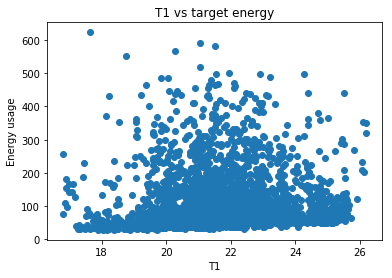

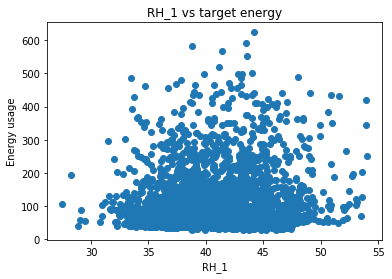

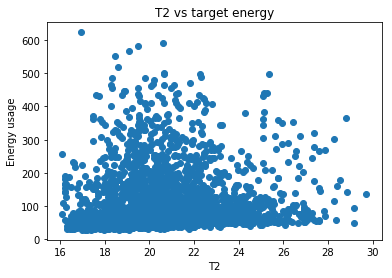

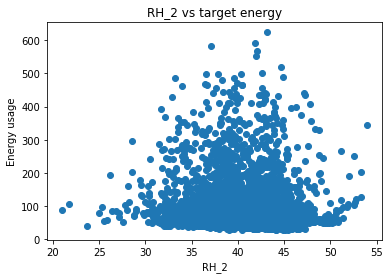

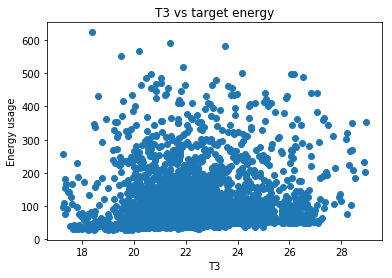

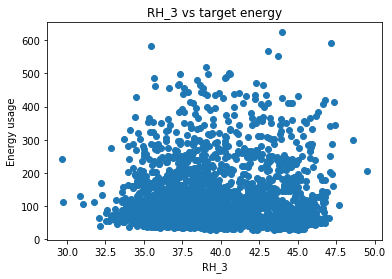

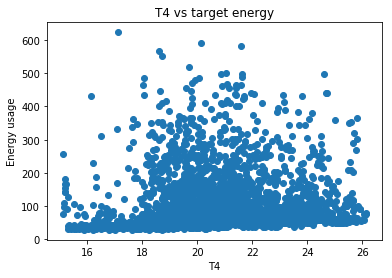

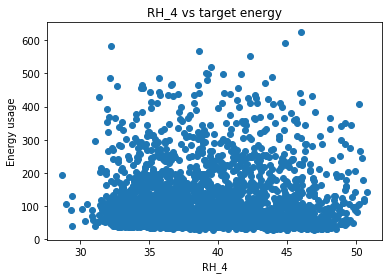

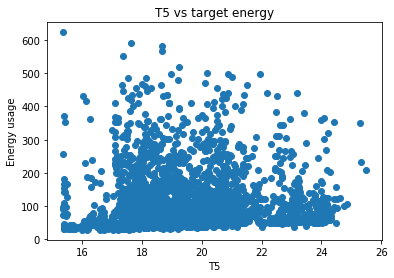

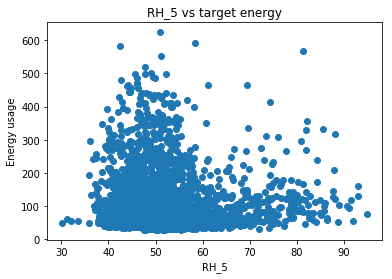

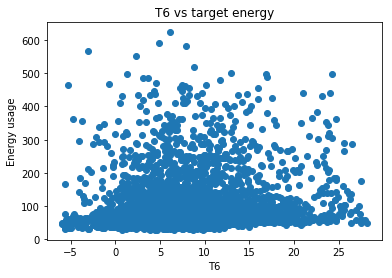

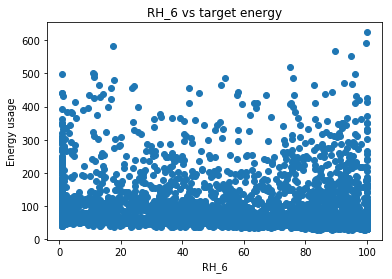

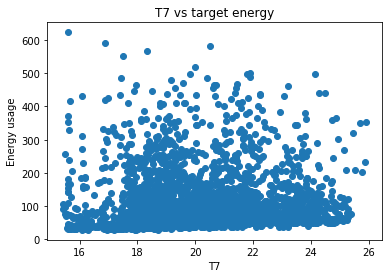

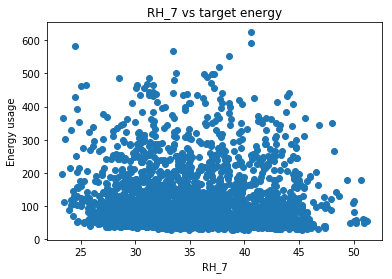

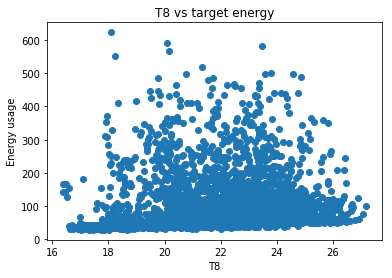

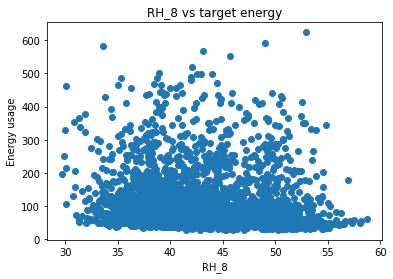

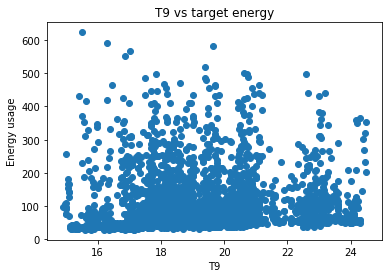

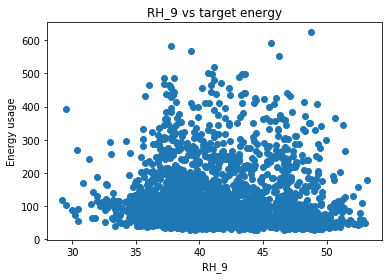

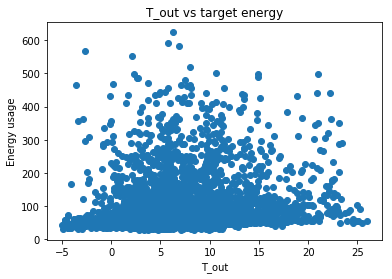

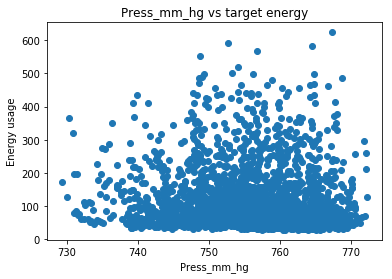

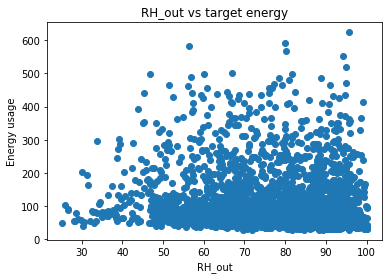

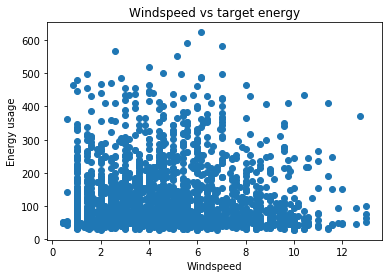

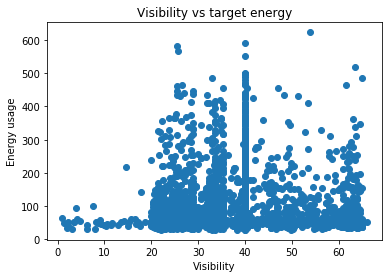

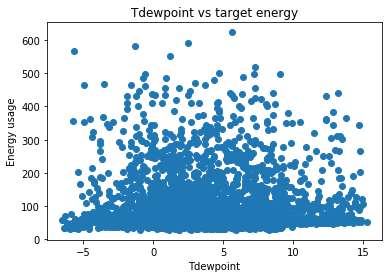

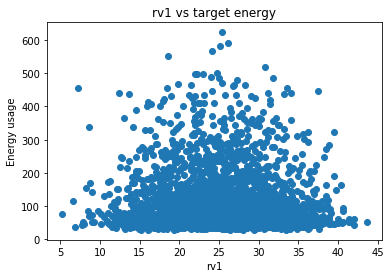

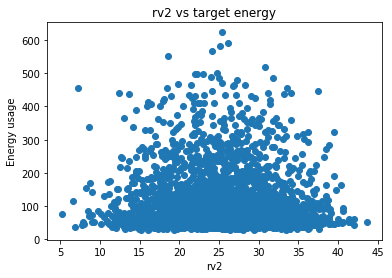

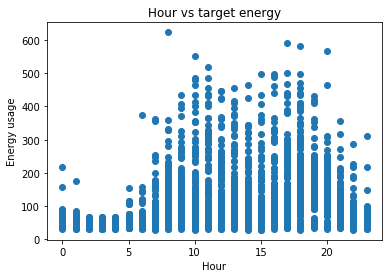

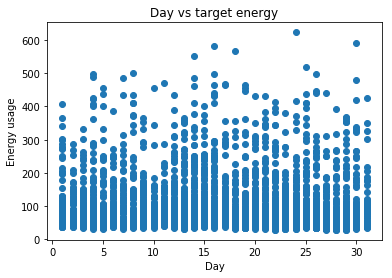

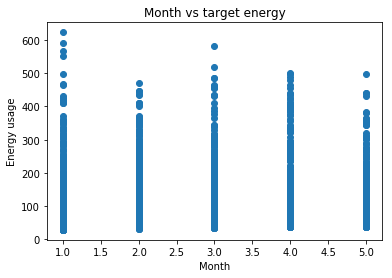

In [7]:
for column in X.iloc[:,:]:
    plt.scatter(X[column], y)
    plt.title(column+' vs target energy')
    plt.xlabel(column)
    plt.ylabel('Energy usage')
    plt.show()

Check for any outliers in the data.

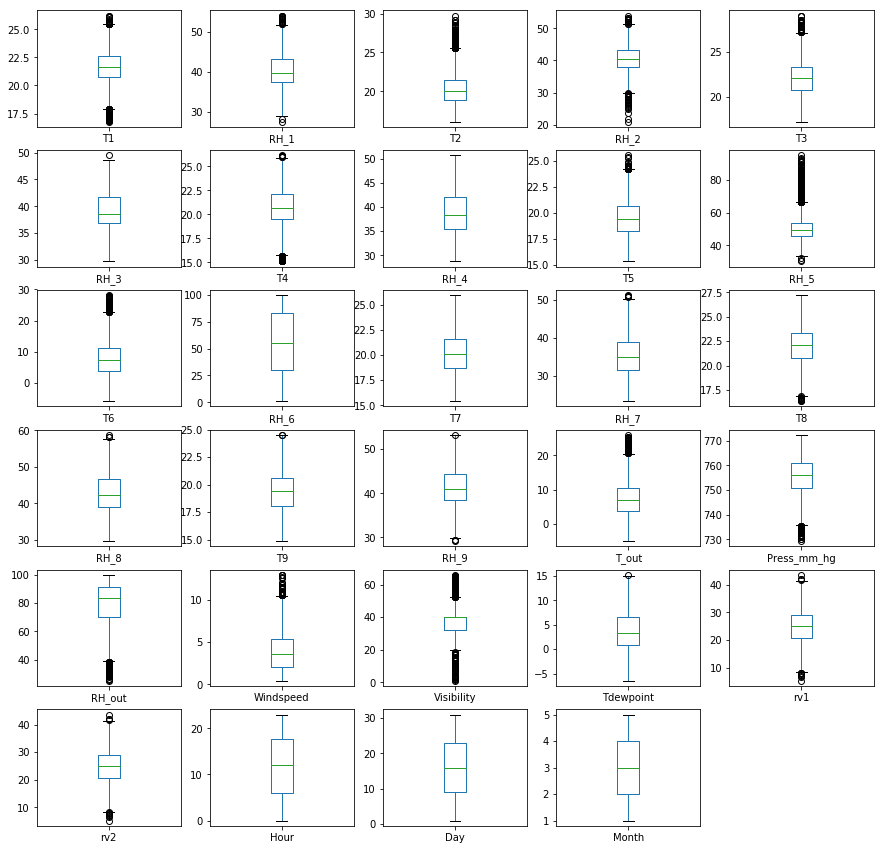

In [8]:
X.plot(kind='box', subplots=True, layout=(6,5),
sharex=False, sharey=False, figsize=(15,15))
plt.show()

This function is used to scale the variable.

In [9]:
def apply_scaling(X):
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)
    return X_scaled

This function returns the heatmap of correlation matrix.

In [10]:
def get_correlation_matrix(X):
    df = X
    df['TARGET_energy'] = y
    correlations = df.corr()
    hm = sns.heatmap(correlations,
                     cmap = "PuBu",
                     cbar=True,
                     annot=True,
                     square=True,
                     fmt='.2f',
                     yticklabels=df.columns,
                     xticklabels=df.columns
    )
    return hm

This function is used to remove the highly correlated features from the dataframe.

In [11]:
def remove_correlation(X):
    df = X
    df['TARGET_energy'] = y
    correlations = df.corr()

    columns = np.full((correlations.shape[0],), True, dtype=bool)
    for i in range(correlations.shape[0]):
        for j in range(i+1, correlations.shape[0]):
            if correlations.iloc[i,j] >= 0.90:
                if columns[j]:
                    columns[j] = False
    selected_columns = df.columns[columns]
    data = df[selected_columns]
    mat = get_correlation_matrix(data)
    return data, mat

This function is called to draw validation curve for the specified model.

In [47]:
def draw_validation_curve(model):
    param_range=np.arange(10, 81, 10)
    train_scores, test_scores = validation_curve(model, X_train, y_train, param_name = 'n_estimators',
                                                param_range=param_range, cv=5)

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.plot(param_range, train_mean, label='Train score', color='blue')
    plt.plot(param_range, test_mean, label='Cross-validation score', color='red')

    plt.legend(loc='best')
    plt.xlabel('estimators')
    plt.ylabel('score')


This function is called to draw learning curve for the specified model.

In [42]:
def draw_learning_curve(model):
    train_sizes,train_scores, test_scores = learning_curve(model, X_train, y_train, 
                                                       train_sizes=[1, 50, 100, 300, 500, 700, 1000], cv=10)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, color='blue', label='Train score')
    plt.plot(train_sizes, test_scores_mean, color='red', label='Cross-validation score')
    
    plt.legend(loc='best')
    plt.xlabel('Training size')
    plt.ylabel('score')

Following tab contains two functions to build models with hyperparater tuning and cross-validation. Hyperparameters for both the models are given as a dictionary.

In [14]:
# Hyper parameters for Random forest regressor
rf_para = {
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['mse', 'mae'],
    'max_depth': [50, 100, 300, 500]
}

# Hyper parameters for Gradient Boosting regressor
gbm_para = {
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'max_features': ['log2', 'sqrt'],
    'criterion': ['friedman_mse', 'mse', 'mae'],
    'learning_rate': [0.1, 0.5, 0.01]
}

# Below function applies hyperparameter tuning with 5-fold cross-validation and determines the best set of parameters
# for Random forest model
def run_random_forest(X_train, X_test, y_train, y_test):
    print("****** Building Random Forest Model *****")
    model = RandomForestRegressor(verbose = 0)
    Regressor = GridSearchCV(model, rf_para, cv=5, verbose = 0)
    Regressor.fit(X_train, y_train)
    y_pred = Regressor.predict(X_test)
    
    print("Train set Accuracy: ", Regressor.score(X_train, y_train))
    print("Validation set Accuracy: ", Regressor.score(X_test, y_test))
    print("Best parameters set for Random Forest Regressor:")
    print(Regressor.best_params_)
    print('')
    return Regressor.best_params_
    
# Below function applies hyperparameter tuning with 5-fold cross-validation and determines the best set of parameters
# for Gradient boosting model
def run_gbm(X_train, X_test, y_train, y_test):
    print("***** Building Gradient Boosting Model *****")
    model = GradientBoostingRegressor()
    Regressor = GridSearchCV(model, gbm_para, cv=5, n_jobs=-1, verbose = 0)
    Regressor.fit(X_train, y_train)
    y_pred = Regressor.predict(X_test)

    print("Train set Accuracy: ", Regressor.score(X_train, y_train))
    print("Validation set Accuracy: ", Regressor.score(X_test, y_test))
    print("Best parameters set for Gradient Boosting Regressor:")
    print(Regressor.best_params_)
    print('')
    return Regressor.best_params_

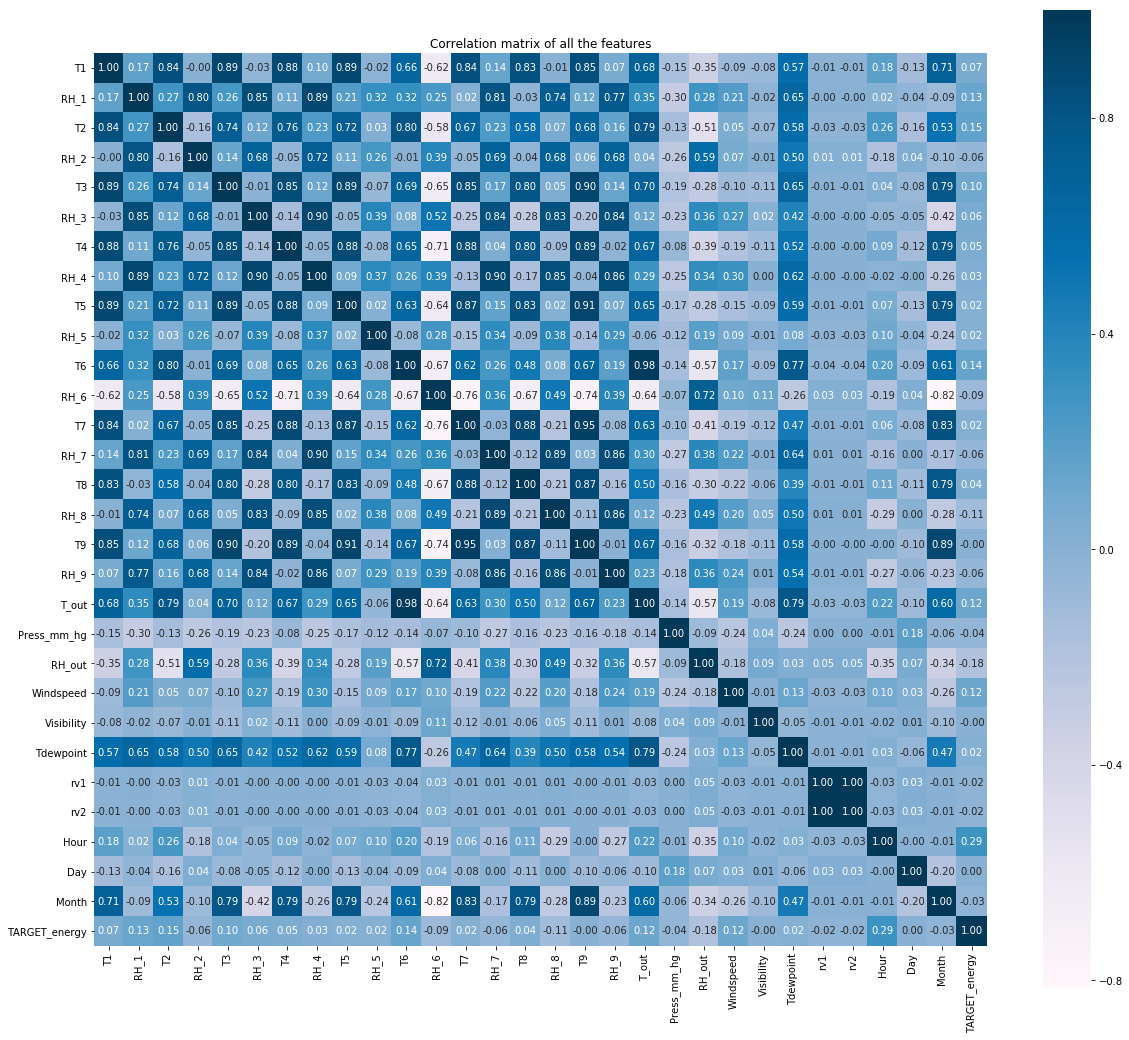

In [15]:
# Drawing correlation matrix of all the features
plt.figure(figsize=(20,18))
mat = get_correlation_matrix(X)
plt.title("Correlation matrix of all the features")
plt.show()

As observed from the above heatmap, many features in the data set are correlated to each other proving the existence of multi collinearity. Therefore, it is necessary to find out only the best features suitable to predict the target energy usage.

Below set of instructions filters out the best features and plots their correlation matrix. Finally selected features with target variable are stored in a dataframe variable named as 'selected_data'.

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


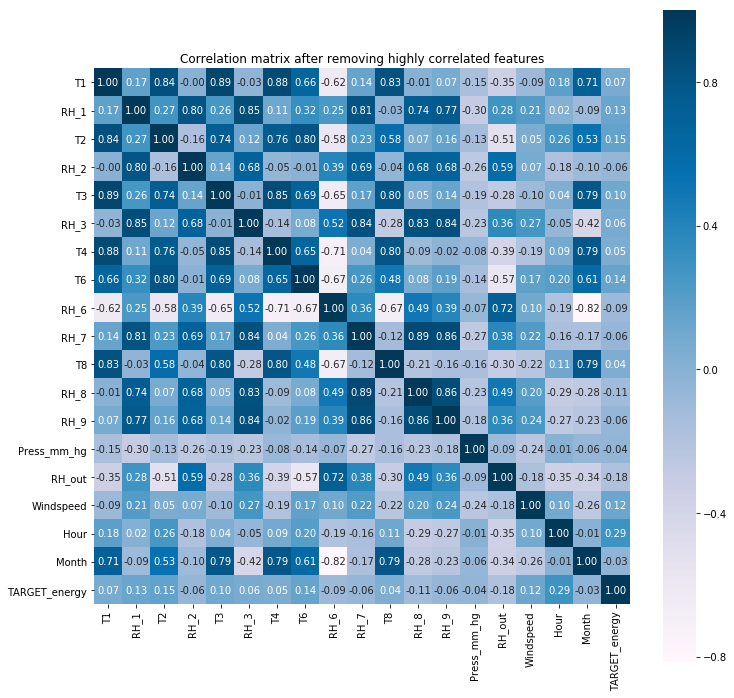

In [19]:
X_scaled = apply_scaling(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values, test_size = 0.20)

selector = SelectKBest(f_regression, k = 20)
X_new = selector.fit_transform(X_train, y_train)
list = selector.get_support().tolist()
cols = X.columns.tolist()
selected_features = []

for i in range(0, len(cols)):
    if(list[i] == True):
        selected_features.append(cols[i])
        
selected_X = X[selected_features]
plt.figure(figsize=(12,12))
selected_data, mat = remove_correlation(selected_X)
plt.title("Correlation matrix after removing highly correlated features")
plt.show()

After scaling and splitting the data, run cross validation with hyper parameter tuning for both Random Forest and Gradient Boosting models to receive the best parameter set. 

In [20]:
selected_data = selected_data.drop(['TARGET_energy'], axis=1)
selected_data = apply_scaling(selected_data)

X_train, X_test, y_train, y_test = train_test_split(selected_data, y.values, test_size = 0.20)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.30)

rf_params = run_random_forest(X_train, X_val, y_train, y_val)
gbm_params = run_gbm(X_train, X_val, y_train, y_val)

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


****** Building Random Forest Model *****


D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change 

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change 

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change 

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change 

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change 

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change 

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change 

Train set Accuracy:  1.0
Validation set Accuracy:  0.34657588987083376
Best parameters set for Random Forest Regressor:
{'bootstrap': False, 'criterion': 'mae', 'max_depth': 500, 'max_features': 'log2'}

***** Building Gradient Boosting Model *****
Train set Accuracy:  0.5931335491315628
Validation set Accuracy:  0.3426735273517475
Best parameters set for Gradient Boosting Regressor:
{'criterion': 'mse', 'learning_rate': 0.1, 'loss': 'ls', 'max_features': 'sqrt'}



Now, build a random forest regressor with best parameters and calculate it's MAE and R2 score values.

In [27]:
modelRF = RandomForestRegressor(**rf_params)
modelRF.fit(X_train, y_train)
y_predRF = modelRF.predict(X_test)

mae = mean_absolute_error(y_test, y_predRF)
r2_value = r2_score(y_test, y_predRF)

print("Mean Absolute error: ", mae)
print("R-squared value: ",r2_value)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Mean Absolute error:  40.8031914893617
R-squared value:  0.24775942770605186


Learning curve for RF model:

Text(0.5, 1.0, 'Learning curve of Random Forest model')

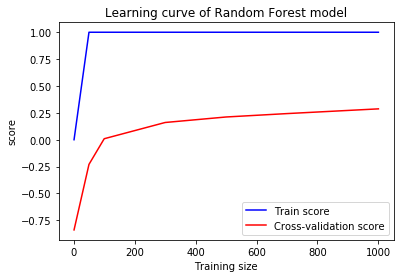

In [43]:
draw_learning_curve(modelRF)
plt.title("Learning curve of Random Forest model")

Validation curve for RF model:

Text(0.5, 1.0, 'Validation curve of Random Forest model')

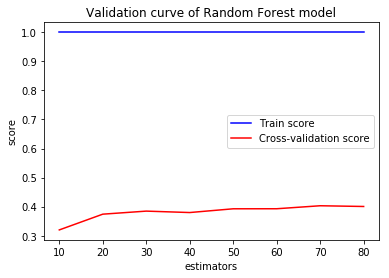

In [48]:
draw_validation_curve(modelRF)
plt.title("Validation curve of Random Forest model")

Next, build the Gradient Boosting Model and calculate it's MAE and R2 score values.

In [37]:
modelGB = GradientBoostingRegressor(**gbm_params)
modelGB.fit(X_train, y_train)
y_predGB = modelGB.predict(X_test)

mae = mean_absolute_error(y_test, y_predGB)
r2_value = r2_score(y_test, y_predGB)

print("Mean Absolute error: ", mae)
print("R-squared value: ",r2_value)

Mean Absolute error:  40.16298260459851
R-squared value:  0.31317504898760207


Learning curve for Gradient Boosting model:

Text(0.5, 1.0, 'Learning curve of Gradient Boosting model')

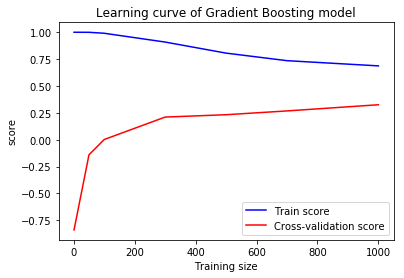

In [45]:
draw_learning_curve(modelGB)
plt.title("Learning curve of Gradient Boosting model")

Validation curve for Gradient Boosting model:

Text(0.5, 1.0, 'Validation curve of Gradient Boosting model')

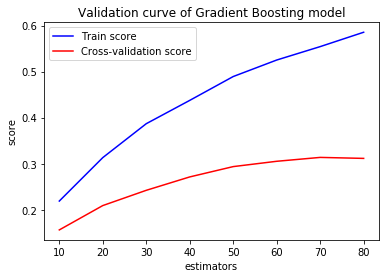

In [49]:
draw_validation_curve(modelGB)
plt.title("Validation curve of Gradient Boosting model")

Plotting the observed energy usage and predicted energy usage 

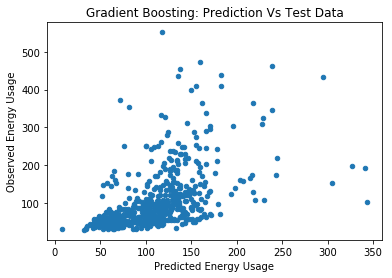

In [50]:
predTest = pd.DataFrame({"prediction": y_predGB, "observed": y_test})
plt.scatter(predTest['prediction'], predTest['observed'])
plt.title("Gradient Boosting: Prediction Vs Test Data")
plt.xlabel("Predicted Energy Usage") 
plt.ylabel("Observed Energy Usage")
plt.show()